# Impact Classifier

The project proposes to leverage machine learning (ML) and natural language processing (NLP) techniques to build a text classifier that automatizes the processing and identification of evidence of social impact in research documents. The proposal aims to solve a classification problem in which the model takes a sentence contained in a research document as input and produces as output a binary answer (1=True, 0=False) that states whether the sentence contains or not evidence of social impact, respectively.

## Load libraries

In [5]:
# import libraries
import numpy as np
import nltk
import os
import pandas as pd
import pickle
import re


# nltk.download("stopwords")

from bs4 import BeautifulSoup
import joblib
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [6]:
# import data
impact_sentences = pd.read_csv("data/social_impact_dataset.csv")

In [7]:
impact_sentences.head()

,id,sentence,label
0,1,the guide to receptors and channels has contri...,0
1,2,the key tools it provides have influenced appr...,0
2,3,it is used widely as a teaching aid for under...,0
3,4,it led to the formation of the guide to pharm...,0
4,5,the cardiff osteological research group corg h...,0


In [8]:
impact_sentences.shape

(1037, 3)

In [9]:
impact_sentences['label'].value_counts()

0    840
1    197
Name: label, dtype: int64

## Explore data

In [15]:
word_black_list = ['research', 'impact', 'uk']
max_items_to_show = 30

Inspect the most used terms used in sentences that **express** evidence of social impact

In [65]:
si_sentences = impact_sentences[impact_sentences['label']==1]['sentence']
si_words = []
for si_sentence in si_sentences:
    for word in si_sentence.split():
        if len(word) > 2 and word not in word_black_list and word not in stopwords.words('english'):
            si_words.append(word)
fdist = FreqDist(si_words)
freq_words_df = pd.DataFrame(fdist.items(), columns=['word', 'frequency'])

In [66]:
freq_words_df.sort_values(by='frequency', ascending=False, inplace=True)

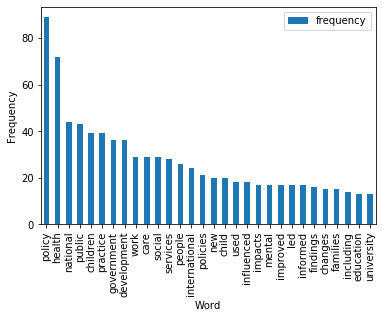

In [67]:
freq_words_df.iloc[0:max_items_to_show,:].plot(x='word', y='frequency', kind='bar')
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.show()

Inspect the most used terms in sentences that **do not express** evidence of social impact

In [68]:
n_si_sentences = impact_sentences[impact_sentences['label']==0]['sentence']
n_fdist = FreqDist(word for n_si_sentence in n_si_sentences 
                        for word in n_si_sentence.split() if len(word) > 2 and word not in stopwords.words('english') and word not in word_black_list)
n_freq_words_df = pd.DataFrame(n_fdist.items(), columns=['word', 'frequency'])

In [69]:
n_freq_words_df.sort_values(by='frequency', ascending=False, inplace=True)

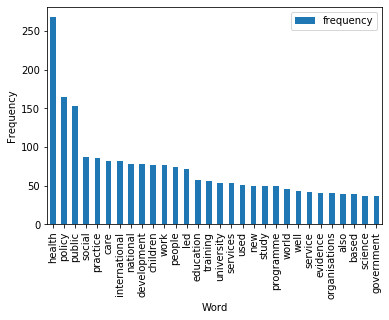

In [70]:
n_freq_words_df.iloc[0:max_items_to_show,:].plot(x='word', y='frequency', kind='bar')
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.show()

Both subsets used pretty similar words. This might be a potential problem.

## Preparing data

Store sentences and labels into separate variables

In [80]:
data, labels = impact_sentences['sentence'], impact_sentences['label']

Remove any html formatting and any non-alpha numeric characters that may appear in the sentences

In [81]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def sentence_to_words(sentence, steeming=False, lemmatization=False):
    text = BeautifulSoup(sentence, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9]", " ", sentence.lower()) # Convert to lower case
    words = word_tokenize(text)   # Split string into words
    words = [word for word in words if word not in stopwords.words("english")] # Remove stopwords
    if steeming:    
        words = [stemmer.stem(word) for word in words]
    if lemmatization:
        words = [lemmatizer.lemmatize(word) for word in words]
    
    return words

In [82]:
cache_dir = "cache"  # directory to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(sentences, labels, cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # Try to read data from cache first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache
    else:
        cache_file = 'preprocessed_data.pkl'
    
    # If cache is missing, then do the processing
    if cache_data is None:
        # Preprocess data to obtain words for each sentence
        words = [sentence_to_words(sentence) for sentence in sentences]
        # Write to cache file for future use
        cache_data = dict(words=words, labels=labels)
        with open(os.path.join(cache_dir, cache_file), "wb") as f:
            pickle.dump(cache_data, f)
        print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words, labels = (cache_data['words'], cache_data['labels'])
    
    return words, labels

In [83]:
# Call the preprocessing function
data, labels = preprocess_data(data, labels, cache_file=None)

Wrote preprocessed data to cache file: preprocessed_data.pkl


In [84]:
data[0]

['guide',
 'receptors',
 'channels',
 'contributed',
 'development',
 'maintenance',
 'intellectual',
 'infrastructure',
 'pharmacology']

### Transform to Bag-of-Words Representation

Transform each sentence into a Bag-of-Words feature representation.

In [85]:
def do_BoW_transformation(sentences, 
                          max_features=None,
                          transformation='tc',  # it can be either 'tc' (term_count), 'tf', or 'tfidf'
                          ngram_range=(1,1)):
    if transformation == 'tc':
        vectorizer = CountVectorizer(max_features=max_features, ngram_range=ngram_range, 
                                     preprocessor=lambda x: x, tokenizer=lambda x: x,
                                     lowercase=False)
    elif transformation == 'tf':
        vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range, 
                                     preprocessor=lambda x: x, tokenizer=lambda x: x,
                                     use_idf=False, lowercase=False)
    elif transformation == 'tfidf':
        vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range, 
                                     preprocessor=lambda x: x, tokenizer=lambda x: x,
                                     lowercase=False)
    bow_features = vectorizer.fit_transform(sentences).toarray()
    
    return bow_features, vectorizer.vocabulary_

In [86]:
def extract_BoW_features(sentences, 
                         vocabulary_size=None,
                         transformation='tc',  # it can be either 'tc' (term_count), 'tf', or 'tfidf'
                         ngram_range=(1,1),
                         cache_dir=cache_dir, 
                         cache_file=None):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
    
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass
    else:
        cache_file = 'bow_features.pkl'
    
    # If cache is missing, then do the processing
    if cache_data is None:
        features, vocabulary = do_BoW_transformation(sentences, 
                                                     vocabulary_size, 
                                                     transformation, 
                                                     ngram_range)
        cache_data = dict(features=features, vocabulary=vocabulary)
        with open(os.path.join(cache_dir, cache_file), "wb") as f:
            joblib.dump(cache_data, f)  # joblib is an enhanced version of pickle that is more efficient for storing NumPy arrays
        print("Wrote features to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        features, vocabulary = (cache_data['features'], cache_data['vocabulary'])
    
    # Return both the extracted features as well as the vocabulary
    return features, vocabulary

#### Text transformations

In [87]:
transformations = ['tc', 'tf', 'tfidf']
transformed_txt = dict()
max_features=[100, 200, 400, 500, 800]
ngram_range=[(1,1),(1,2),(1,3)]
for transformation in transformations:
    transformed_txt[transformation] = dict()
    for max_feature in max_features:
        cache_file_name = 'bow_features_{0}_{1}.pkl'.format(transformation, max_feature)
        data_transformed, _ = extract_BoW_features(data, 
                                                   vocabulary_size=max_feature, 
                                                   cache_file=cache_file_name, 
                                                   transformation=transformation) 
        transformed_txt[transformation][str(max_feature)] = data_transformed

Wrote features to cache file: bow_features_tc_100.pkl
Wrote features to cache file: bow_features_tc_200.pkl
Wrote features to cache file: bow_features_tc_400.pkl
Wrote features to cache file: bow_features_tc_500.pkl
Wrote features to cache file: bow_features_tc_800.pkl
Wrote features to cache file: bow_features_tf_100.pkl
Wrote features to cache file: bow_features_tf_200.pkl
Wrote features to cache file: bow_features_tf_400.pkl
Wrote features to cache file: bow_features_tf_500.pkl
Wrote features to cache file: bow_features_tf_800.pkl
Wrote features to cache file: bow_features_tfidf_100.pkl
Wrote features to cache file: bow_features_tfidf_200.pkl
Wrote features to cache file: bow_features_tfidf_400.pkl
Wrote features to cache file: bow_features_tfidf_500.pkl
Wrote features to cache file: bow_features_tfidf_800.pkl


Let's do some sanity check

In [88]:
transformed_txt['tf']['200'][0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.70710678, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.70710678, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

## Train and test ML algorithms with the differente text transformations

Trainining, testing, and validating machine learning algorithms that are reported to perform well on unbalanced, small, and textual datasets.

In [89]:
def get_classifier(algorithm_name):
    if algorithm_name == 'NB':
        classifier = GaussianNB()
    elif algorithm_name == 'SVMR':
        classifier = SVC(kernel='rbf', gamma='auto')
    elif algorithm_name == 'SVML':
        classifier = SVC(kernel='linear', gamma='auto')
    elif algorithm_name == 'LR1':
        classifier = LogisticRegression(penalty='l1', solver='liblinear')
    elif algorithm_name == 'LR2':
        classifier = LogisticRegression(penalty='l2', solver='liblinear')
    elif algorithm_name == 'RF':
        params = {
            'n_estimators': 600,
            'min_samples_split': 5,
            'min_samples_leaf': 1,
            'max_features': 'auto',
            'max_depth': 50,
            'bootstrap': True
        }
        classifier = RandomForestClassifier(**params)
    elif algorithm_name == 'XGB':
        classifier = XGBClassifier(objective="binary:logistic", eta=0.2, gamma=4, min_child_weight=6)
    else:
        print("Unknown algorithm: {0}",format(algorithm_name))

    return classifier

In [90]:
def do_cross_validation(kfold, classifier, data, labels):
    scores = {
        'balanced_accuracy': [],
        'f1': [],
        'recall': [],
        'precision': []
    }
    for train_index, test_index in kfold.split(data):   
        kf_X_train, kf_X_test = data[train_index], data[test_index]
        kf_y_train, kf_y_test = labels[train_index], labels[test_index]        
        classifier.fit(kf_X_train, kf_y_train)
        y_pred = classifier.predict(kf_X_test)
        scores['balanced_accuracy'].append(metrics.balanced_accuracy_score(kf_y_test, y_pred))
        scores['f1'].append(metrics.f1_score(kf_y_test, y_pred))
        scores['recall'].append(metrics.recall_score(kf_y_test, y_pred))
        scores['precision'].append(metrics.precision_score(kf_y_test, y_pred))
    return scores

In [92]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
algorithms = ['NB', 'SVMR', 'SVML', 'LR1', 'LR2', 'RF', 'XGB']
outputs = []

%time  # record time spend in executing the training

for transformation in transformations:
    for max_feature in max_features:
        t_data = transformed_txt[transformation][str(max_feature)]
        for algorithm in algorithms:
            print('Transformation: {0}, Max Features: {1}, Algorithm: {2}'.format(transformation, max_feature, 
                                                                                  algorithm))
            classifier = get_classifier(algorithm)
            scores = do_cross_validation(kfold, classifier, t_data, labels)
            outputs.append(
                {
                    'algorithm': algorithm,
                    'transformation': transformation,
                    'max_features': max_feature,
                    'metrics': scores
                }
            )

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
Transformation: tc, Max Features: 100, Algorithm: NB
Transformation: tc, Max Features: 100, Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tc, Max Features: 100, Algorithm: SVML
Transformation: tc, Max Features: 100, Algorithm: LR1
Transformation: tc, Max Features: 100, Algorithm: LR2
Transformation: tc, Max Features: 100, Algorithm: RF
Transformation: tc, Max Features: 100, Algorithm: XGB


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 200, Algorithm: NB
Transformation: tc, Max Features: 200, Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tc, Max Features: 200, Algorithm: SVML
Transformation: tc, Max Features: 200, Algorithm: LR1
Transformation: tc, Max Features: 200, Algorithm: LR2
Transformation: tc, Max Features: 200, Algorithm: RF


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 200, Algorithm: XGB


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 400, Algorithm: NB
Transformation: tc, Max Features: 400, Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tc, Max Features: 400, Algorithm: SVML
Transformation: tc, Max Features: 400, Algorithm: LR1
Transformation: tc, Max Features: 400, Algorithm: LR2
Transformation: tc, Max Features: 400, Algorithm: RF


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 400, Algorithm: XGB


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 500, Algorithm: NB
Transformation: tc, Max Features: 500, Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tc, Max Features: 500, Algorithm: SVML
Transformation: tc, Max Features: 500, Algorithm: LR1
Transformation: tc, Max Features: 500, Algorithm: LR2
Transformation: tc, Max Features: 500, Algorithm: RF


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 500, Algorithm: XGB


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, Algorithm: NB
Transformation: tc, Max Features: 800, Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tc, Max Features: 800, Algorithm: SVML
Transformation: tc, Max Features: 800, Algorithm: LR1
Transformation: tc, Max Features: 800, Algorithm: LR2
Transformation: tc, Max Features: 800, Algorithm: RF


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tc, Max Features: 800, Algorithm: XGB


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tf, Max Features: 100, Algorithm: NB
Transformation: tf, Max Features: 100, Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, Algorithm: SVML


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 100, Algorithm: LR1
Transformation: tf, Max Features: 100, Algorithm: LR2
Transformation: tf, Max Features: 100, Algorithm: RF
Transformation: tf, Max Features: 100, Algorithm: XGB


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tf, Max Features: 200, Algorithm: NB
Transformation: tf, Max Features: 200, Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 200, Algorithm: SVML


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tf, Max Features: 200, Algorithm: LR1
Transformation: tf, Max Features: 200, Algorithm: LR2


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tf, Max Features: 200, Algorithm: RF


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tf, Max Features: 200, Algorithm: XGB


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tf, Max Features: 400, Algorithm: NB
Transformation: tf, Max Features: 400, Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, Algorithm: SVML


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tf, Max Features: 400, Algorithm: LR1
Transformation: tf, Max Features: 400, Algorithm: LR2


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tf, Max Features: 400, Algorithm: RF


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 400, Algorithm: XGB
Transformation: tf, Max Features: 500, Algorithm: NB
Transformation: tf, Max Features: 500, Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, Algorithm: SVML


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tf, Max Features: 500, Algorithm: LR1
Transformation: tf, Max Features: 500, Algorithm: LR2


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tf, Max Features: 500, Algorithm: RF


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 500, Algorithm: XGB
Transformation: tf, Max Features: 800, Algorithm: NB
Transformation: tf, Max Features: 800, Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, Algorithm: SVML
Transformation: tf, Max Features: 800, Algorithm: LR1
Transformation: tf, Max Features: 800, Algorithm: LR2


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tf, Max Features: 800, Algorithm: RF


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tf, Max Features: 800, Algorithm: XGB
Transformation: tfidf, Max Features: 100, Algorithm: NB
Transformation: tfidf, Max Features: 100, Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, Algorithm: SVML


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 100, Algorithm: LR1
Transformation: tfidf, Max Features: 100, Algorithm: LR2


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tfidf, Max Features: 100, Algorithm: RF


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tfidf, Max Features: 100, Algorithm: XGB


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tfidf, Max Features: 200, Algorithm: NB
Transformation: tfidf, Max Features: 200, Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 200, Algorithm: SVML


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tfidf, Max Features: 200, Algorithm: LR1
Transformation: tfidf, Max Features: 200, Algorithm: LR2


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tfidf, Max Features: 200, Algorithm: RF


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tfidf, Max Features: 200, Algorithm: XGB
Transformation: tfidf, Max Features: 400, Algorithm: NB
Transformation: tfidf, Max Features: 400, Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 400, Algorithm: SVML


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tfidf, Max Features: 400, Algorithm: LR1
Transformation: tfidf, Max Features: 400, Algorithm: LR2


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tfidf, Max Features: 400, Algorithm: RF


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tfidf, Max Features: 400, Algorithm: XGB
Transformation: tfidf, Max Features: 500, Algorithm: NB
Transformation: tfidf, Max Features: 500, Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 500, Algorithm: SVML


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tfidf, Max Features: 500, Algorithm: LR1
Transformation: tfidf, Max Features: 500, Algorithm: LR2


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tfidf, Max Features: 500, Algorithm: RF


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tfidf, Max Features: 500, Algorithm: XGB
Transformation: tfidf, Max Features: 800, Algorithm: NB
Transformation: tfidf, Max Features: 800, Algorithm: SVMR


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, Algorithm: SVML


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tfidf, Max Features: 800, Algorithm: LR1


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Transformation: tfidf, Max Features: 800, Algorithm: LR2


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tfidf, Max Features: 800, Algorithm: RF


/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jorge/Dropbox/Development/impact-classifier/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Transformation: tfidf, Max Features: 800, Algorithm: XGB


Save results into a dataframe

In [93]:
output_df = pd.DataFrame(columns=['algorithm', 'transformation', 'max_features', 'mean_balanced_accuracy', 
                                  'mean_recall', 'mean_precision', 'mean_f1'])
for output in outputs:
    row = {
        'algorithm': output['algorithm'],
        'transformation': output['transformation'],
        'max_features': output['max_features'],
        'mean_balanced_accuracy': round(np.array(output['metrics']['balanced_accuracy']).mean(), 2),
        'mean_recall': round(np.array(output['metrics']['recall']).mean(), 2),
        'mean_precision': round(np.array(output['metrics']['precision']).mean(), 2),
        'mean_f1': round(np.array(output['metrics']['f1']).mean(), 2),
    }
    output_df = output_df.append(row, ignore_index=True)

In [94]:
output_df.head()

,algorithm,transformation,max_features,mean_balanced_accuracy,mean_recall,mean_precision,mean_f1
0,NB,tc,100,0.63,0.50,0.34,0.39
1,SVMR,tc,100,0.50,0.00,0.00,0.00
2,SVML,tc,100,0.57,0.19,0.46,0.26
3,LR1,tc,100,0.59,0.22,0.52,0.30
4,LR2,tc,100,0.59,0.22,0.51,0.30


Look at the top-5 models by `Balanced Accuracy`

In [95]:
output_df.sort_values(by='mean_balanced_accuracy', ascending=False).head(5)

,algorithm,transformation,max_features,mean_balanced_accuracy,mean_recall,mean_precision,mean_f1
0,NB,tc,100,0.63,0.50,0.34,0.39
9,SVML,tc,200,0.62,0.33,0.45,0.37
11,LR2,tc,200,0.62,0.30,0.53,0.38
16,SVML,tc,400,0.61,0.35,0.39,0.36
31,LR1,tc,800,0.60,0.27,0.44,0.33


Inspect the top-5 models by `Recall`

In [96]:
output_df.sort_values(by='mean_recall', ascending=False).head(5)

,algorithm,transformation,max_features,mean_balanced_accuracy,mean_recall,mean_precision,mean_f1
14,NB,tc,400,0.56,0.81,0.22,0.34
84,NB,tfidf,400,0.55,0.72,0.21,0.32
7,NB,tc,200,0.58,0.72,0.23,0.35
49,NB,tf,400,0.55,0.70,0.21,0.32
21,NB,tc,500,0.54,0.68,0.21,0.31


Inspect the top-5 models by `Precision`

In [97]:
output_df.sort_values(by='mean_precision', ascending=False).head(5)

,algorithm,transformation,max_features,mean_balanced_accuracy,mean_recall,mean_precision,mean_f1
53,LR2,tf,400,0.53,0.07,0.68,0.12
60,LR2,tf,500,0.53,0.06,0.68,0.11
62,XGB,tf,500,0.52,0.05,0.67,0.08
39,LR2,tf,100,0.53,0.08,0.66,0.13
59,LR1,tf,500,0.55,0.11,0.66,0.18


Inspect the top-5 models by `F1`

In [98]:
output_df.sort_values(by='mean_f1', ascending=False).head(5)

,algorithm,transformation,max_features,mean_balanced_accuracy,mean_recall,mean_precision,mean_f1
0,NB,tc,100,0.63,0.50,0.34,0.39
11,LR2,tc,200,0.62,0.30,0.53,0.38
9,SVML,tc,200,0.62,0.33,0.45,0.37
16,SVML,tc,400,0.61,0.35,0.39,0.36
7,NB,tc,200,0.58,0.72,0.23,0.35


Save results to a csv

In [99]:
experiment_dir = 'experiments'  # directory to store experiments
os.makedirs(experiment_dir, exist_ok=True)  # ensure the directory exists
output_df.to_csv(experiment_dir+'/e_20032020.csv', index=False)

In [167]:
from sklearn.model_selection import cross_val_score
rf_classifier = RandomForestClassifier(n_estimators=1000)
scores = cross_val_score(rf_classifier,data_tc, labels, scoring="balanced_accuracy", cv=10)
print(scores)

[0.67853881 0.51392694 0.60205479 0.64908676 0.56187215 0.62853881
 0.6109589  0.57945205 0.69027778 0.57222222]


#### Hyperparameter tuning

In [186]:
# Set the parameters
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 7, 10]
min_samples_leaf = [1, 2, 3]
bootstrap = [True, False]
# Set parameters grid 
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 7, 10], 'min_samples_leaf': [1, 2, 3], 'bootstrap': [True, False]}


In [193]:
rf_classifier = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_classifier, param_distributions = param_grid, 
                               n_iter = 50, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, Y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [194]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': True}